In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
import pandas as pd
import numpy as np

In [9]:
from tqdm.auto import tqdm

In [ ]:
file_path = "/content/drive/MyDrive/Data DPE/batiment_groupe_dpe_representatif_logement.csv"

# Estimation du nombre total de lignes (en comptant simplement les retours à la ligne)
total_lines = sum(1 for _ in open(file_path, 'r', encoding='utf-8'))

# Calcul de la taille de chaque chunk comme 10% du total des lignes
chunk_size = total_lines // 10

# Lecture du fichier par morceaux avec barre de progression
tqdm_iterator = tqdm(pd.read_csv(file_path, chunksize=chunk_size, low_memory=False), total=10)
dataframes = []
for chunk in tqdm_iterator:
    dataframes.append(chunk)

# Concaténation des morceaux de DataFrame en un seul DataFrame
df = pd.concat(dataframes, ignore_index=True)

  0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
del dataframes  # Supprime la liste des dataframes

In [ ]:
for col in df.columns:
    if df[col].dtype == 'float64':
        df[col] = df[col].astype('float16')
    elif df[col].dtype == 'int64':
        df[col] = df[col].astype('int16')

/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:138: RuntimeWarning: overflow encountered in cast
  return arr.astype(dtype, copy=True)
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:138: RuntimeWarning: overflow encountered in cast
  return arr.astype(dtype, copy=True)
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:138: RuntimeWarning: overflow encountered in cast
  return arr.astype(dtype, copy=True)
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:138: RuntimeWarning: overflow encountered in cast
  return arr.astype(dtype, copy=True)
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:138: RuntimeWarning: overflow encountered in cast
  return arr.astype(dtype, copy=True)
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:138: RuntimeWarning: overflow encountered in cast
  return arr.astype(dtype, copy=True)
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes

In [ ]:
filtered_df = df[(df['type_dpe'] == 'dpe arrêté 2021 3cl logement') |
                 (df['type_dpe'] == 'dpe arrêté 2021 3cl immeuble')]

In [ ]:
del df

In [ ]:
filtered_df_na = filtered_df[filtered_df['conso_5_usages_ep_m2'].notna()]

In [ ]:
del filtered_df

In [ ]:
filtered_df_na_chauf = filtered_df_na[
    filtered_df_na['type_installation_chauffage'].notna() &
    filtered_df_na['surface_habitable_logement'].notna() &
    filtered_df_na['type_installation_ecs'].notna()&
    filtered_df_na['type_vitrage']&
    filtered_df_na["type_isolation_mur_exterieur"]&
    filtered_df_na["type_isolation_plancher_bas"]&
    filtered_df_na["type_isolation_plancher_haut"]
].copy()

In [ ]:
filtered_df_na_chauf['type_energie_climatisation'].fillna('aucun', inplace=True)
filtered_df_na_chauf['type_generateur_climatisation'].fillna('aucun', inplace=True)
filtered_df_na_chauf['type_energie_chauffage_appoint'].fillna('aucun', inplace=True)
filtered_df_na_chauf['type_production_energie_renouvelable'].fillna('aucun', inplace=True)
filtered_df_na_chauf['traversant'].fillna('non traversant', inplace=True)
filtered_df_na_chauf.fillna('inconnu', inplace=True)

In [ ]:
del filtered_df_na

In [ ]:
zone_climatique = {
    'H1': [1, 2, 3, 5, 8, 10, 14, 15, 19, 21, 23, 25, 27, 28, 38, 39, 42, 43, 45, 51, 52, 54, 55, 57, 58, 59, 60, 61, 62, 63, 67, 68, 69, 70, 71, 73, 74, 75, 76, 77, 78, 80, 87, 88, 89, 90, 91, 92, 93, 94, 95],
    'H2': [4, 7, 9, 12, 16, 17, 18, 22, 24, 26, 29, 31, 32, 33, 35, 36, 37, 40, 41, 44, 46, 47, 48, 49, 50, 53, 56, 64, 65, 72, 79, 81, 82, 84, 85, 86],
    'H3': [6, 11, 13, 20, 30, 34, 66, 83]
}
departement_to_zone = {}
for zone, departements in zone_climatique.items():
    for dep in departements:
        departement_to_zone[str(dep).zfill(2)] = zone

In [ ]:
filtered_df_na_chauf['code_departement_insee'] = filtered_df_na_chauf['code_departement_insee'].astype(str).str.zfill(2)
filtered_df_na_chauf['zone_climatique'] = filtered_df_na_chauf['code_departement_insee'].map(departement_to_zone)

In [ ]:
unmapped = filtered_df_na_chauf[filtered_df_na_chauf['zone_climatique'].isna()]
if not unmapped.empty:
    print("Il y a des départements qui n'ont pas été mappés :")
    print(unmapped['code_departement_insee'].unique())
else:
    print("Tous les départements ont été correctement mappés.")

Il y a des départements qui n'ont pas été mappés :
['2A' '2B']


In [ ]:
filtered_df_save = filtered_df_na_chauf[
    filtered_df_na_chauf['zone_climatique'].notna()
].copy()

In [ ]:
del filtered_df_na_chauf

In [ ]:
features_column=["type_batiment_dpe","periode_construction_dpe","surface_habitable_logement","type_installation_chauffage","type_generateur_chauffage","type_energie_chauffage_appoint","chauffage_solaire","nb_generateur_chauffage","nb_installation_chauffage","type_energie_climatisation","type_generateur_climatisation","type_installation_ecs","type_energie_ecs","type_generateur_ecs","ecs_solaire","nb_generateur_ecs","nb_installation_ecs","type_ventilation","type_production_energie_renouvelable","type_vitrage","type_materiaux_menuiserie","type_gaz_lame","type_fermeture","traversant","type_isolation_mur_exterieur","type_isolation_plancher_bas","type_isolation_plancher_haut","zone_climatique"]

In [ ]:
y_column=["conso_5_usages_ep_m2","conso_5_usages_ef_m2","emission_ges_5_usages_m2"]

In [ ]:
filtered_df_save.reset_index(drop=True, inplace=True)
chemin_du_fichier_temporaire = "/content/drive/MyDrive/Data DPE/data_filtre.csv"
filtered_df_save.to_csv(chemin_du_fichier_temporaire, index=False)

In [ ]:
# Comptez le nombre total de lignes dans le fichier CSV
nombre_total_lignes = sum(1 for line in open('/content/drive/MyDrive/Data DPE/data_filtre.csv', 'r'))

# Calculez les lignes à sauter (80% des données)
lignes_a_sauter = [i for i in range(1, nombre_total_lignes) if i % 5 != 0]

# Chargez le DataFrame en ne lisant que les lignes nécessaires (20%)
filtered_df_save = pd.read_csv('/content/drive/MyDrive/Data DPE/data_filtre.csv', skiprows=lignes_a_sauter, low_memory=False)

In [10]:
filtered_df_save=pd.read_csv("/content/drive/MyDrive/Data DPE/data_filtre.csv",low_memory=False)

In [14]:
X=filtered_df_save[features_column].copy()
y=filtered_df_save[y_column].copy()

In [15]:
del filtered_df_save

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

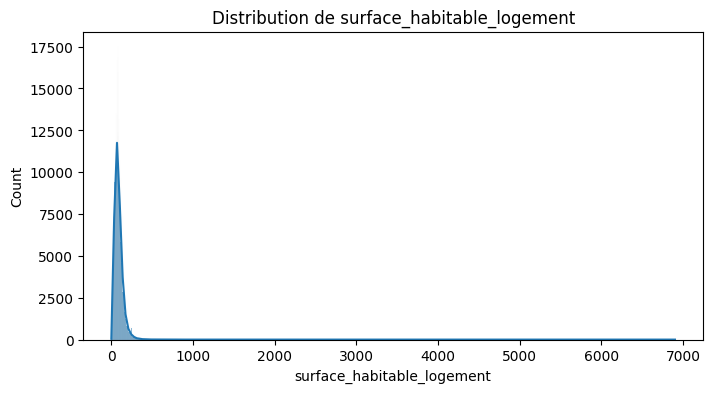

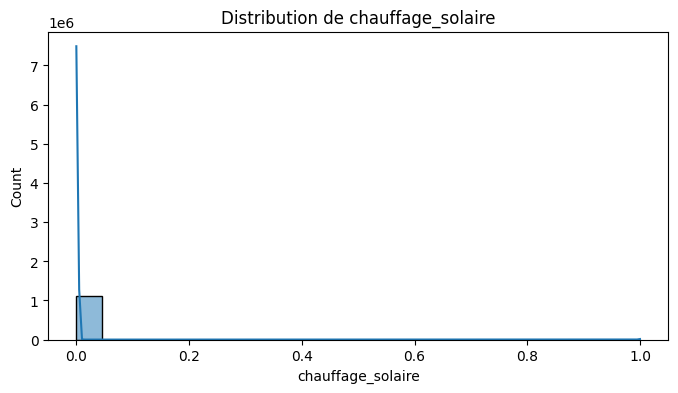

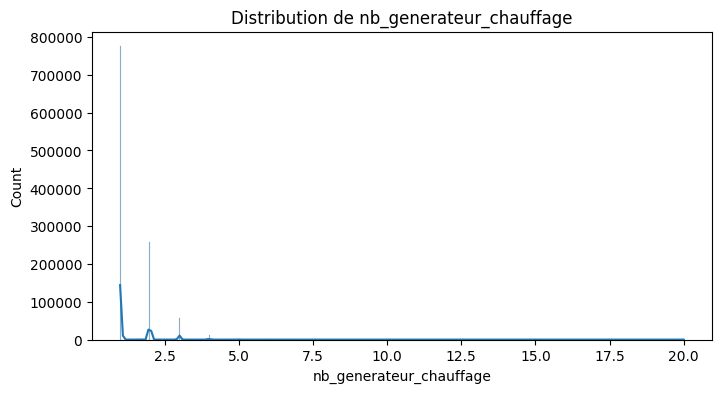

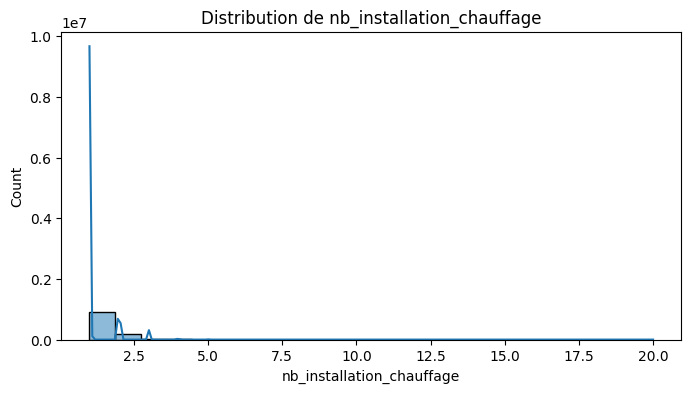

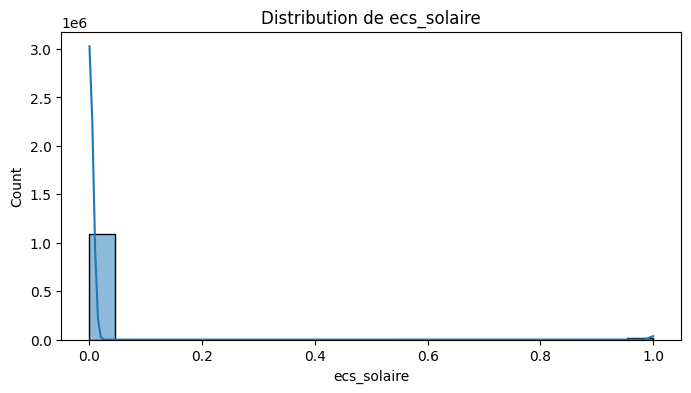

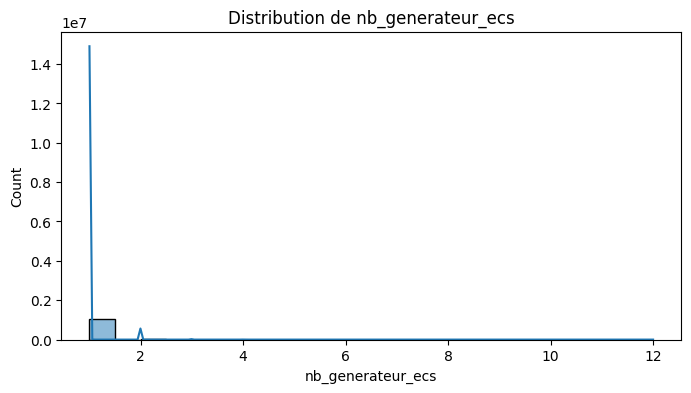

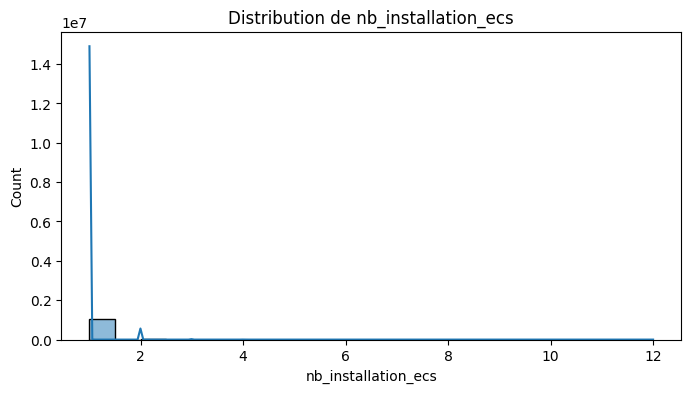

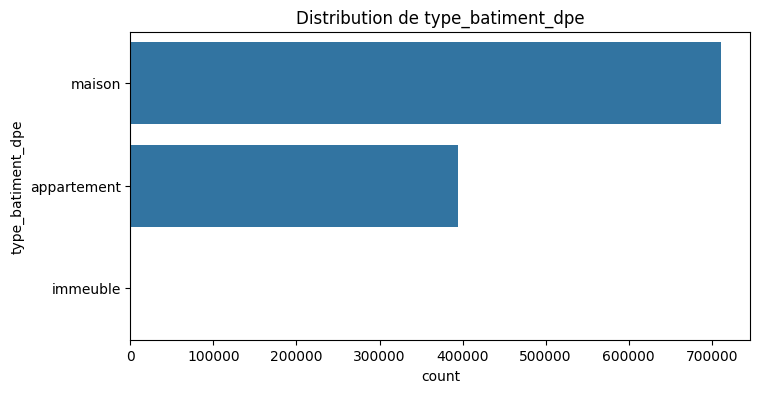

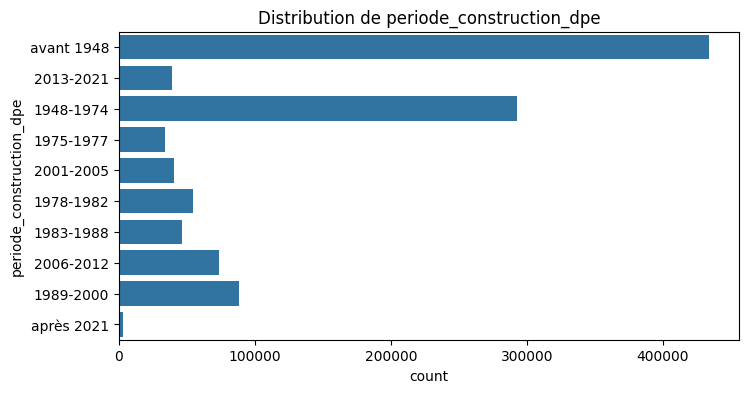

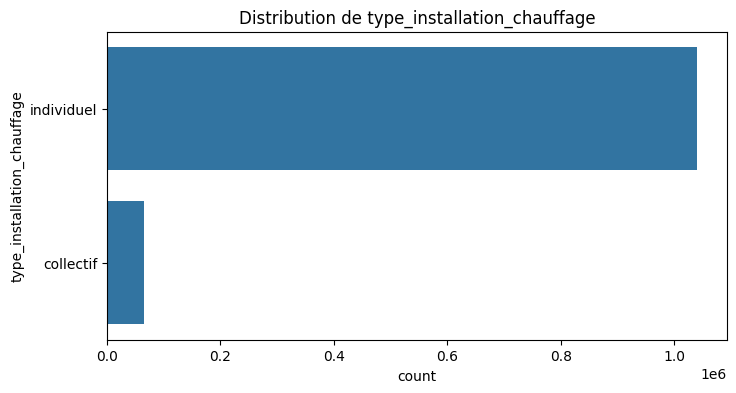

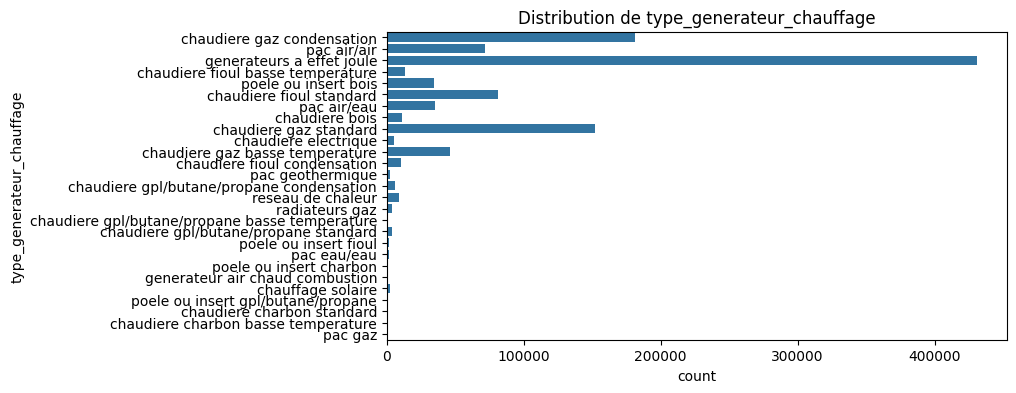

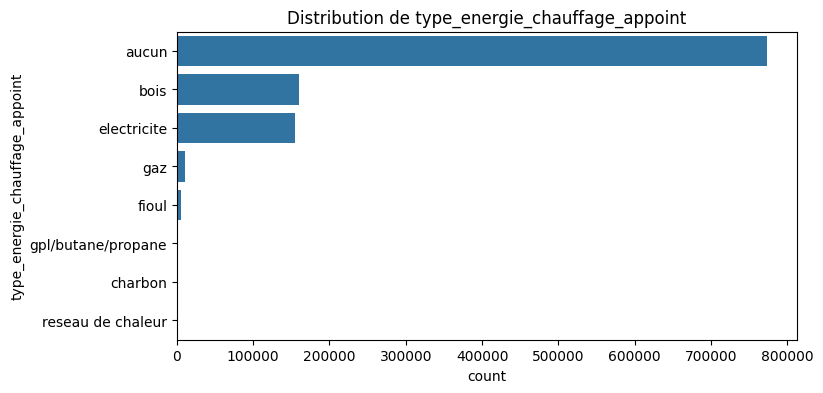

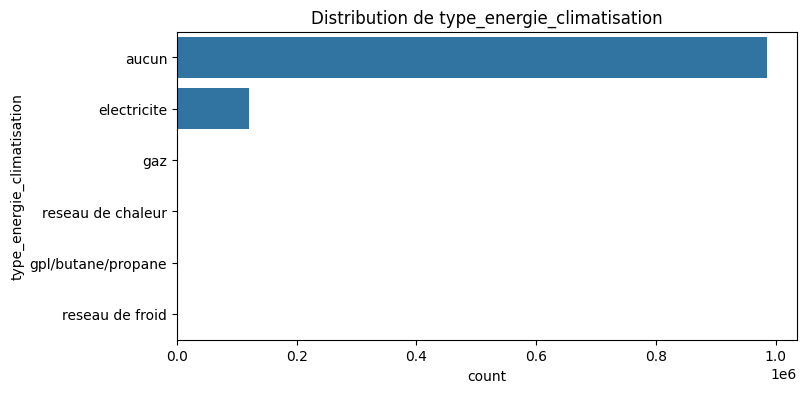

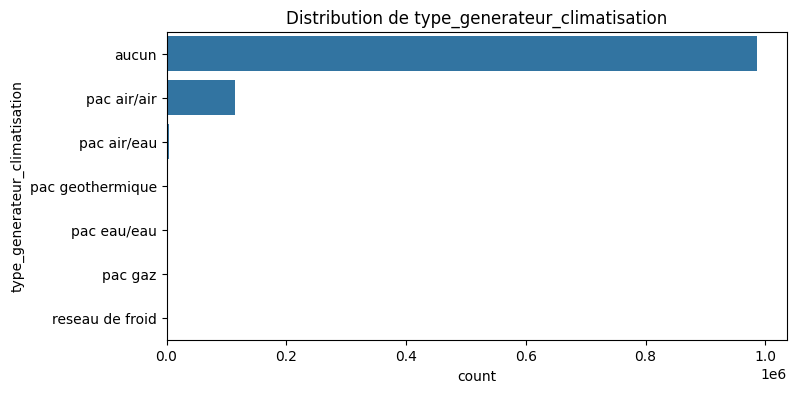

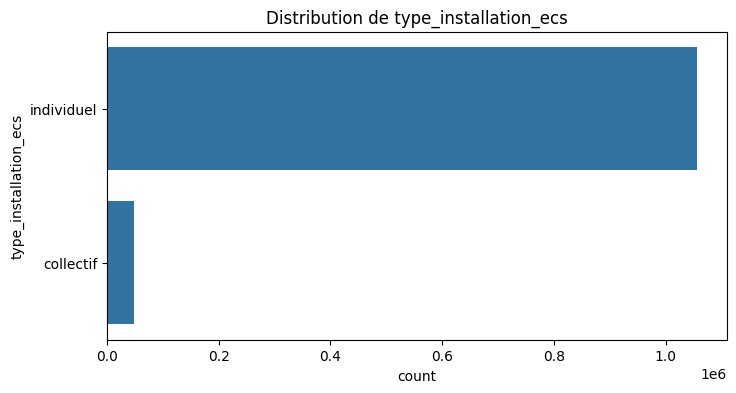

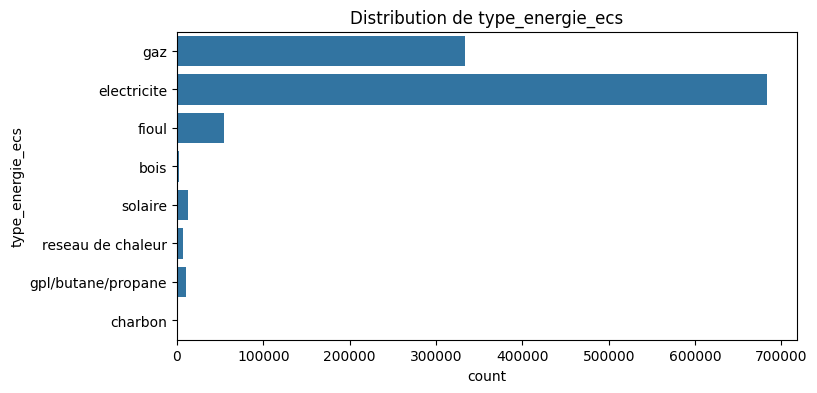

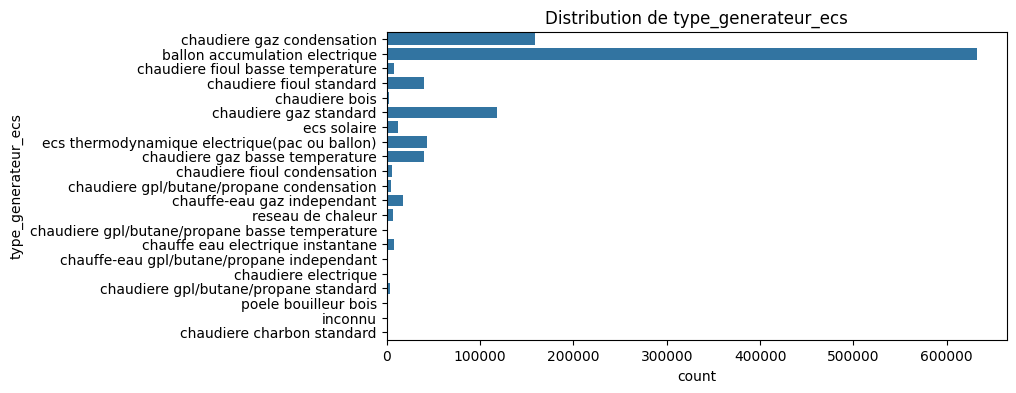

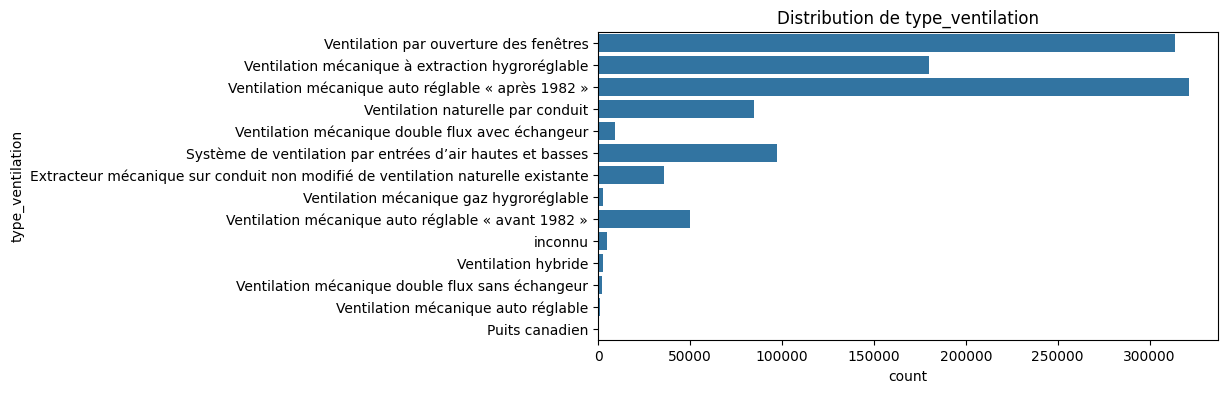

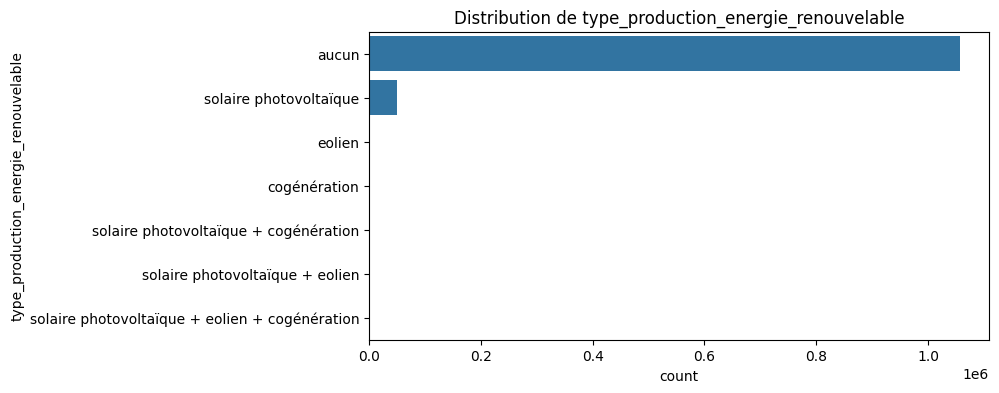

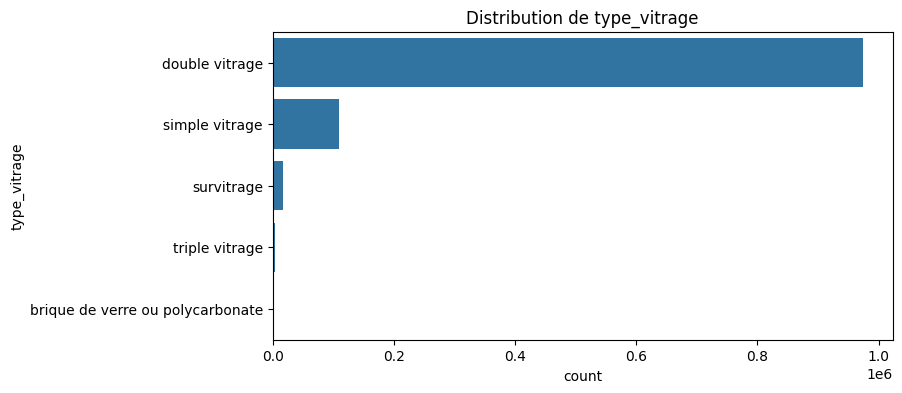

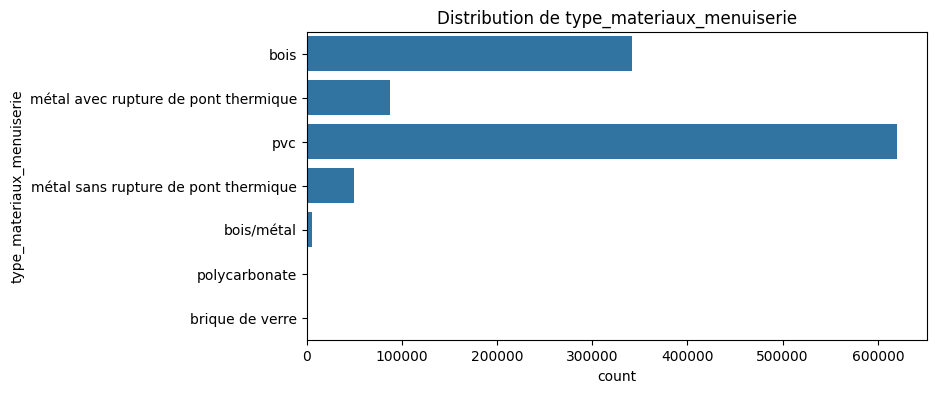

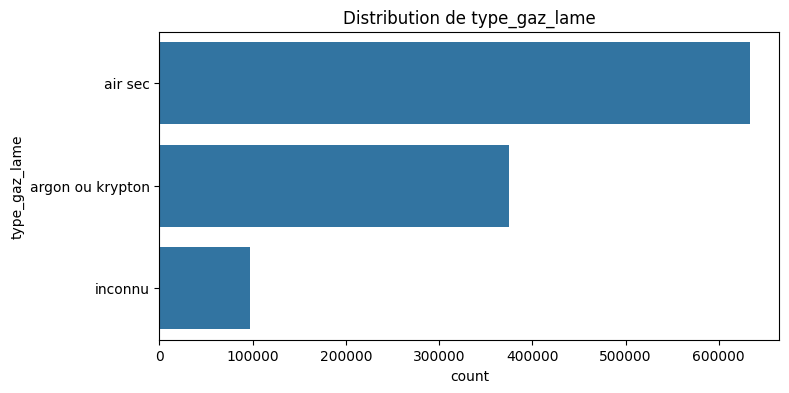

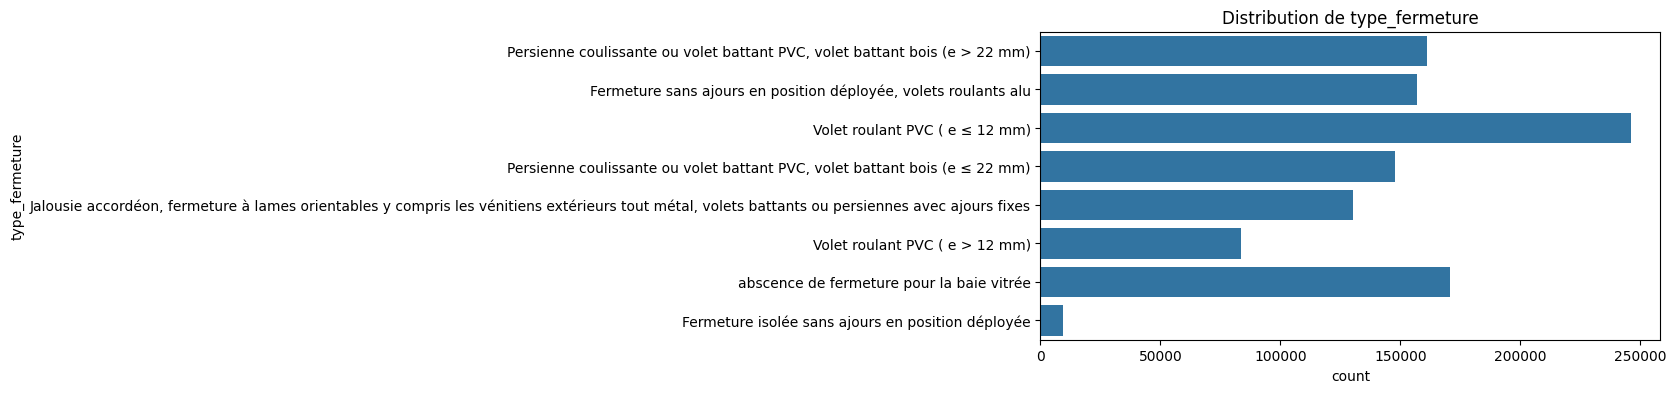

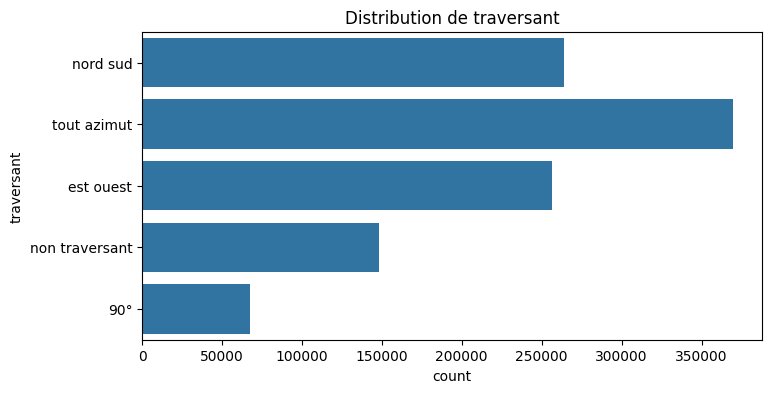

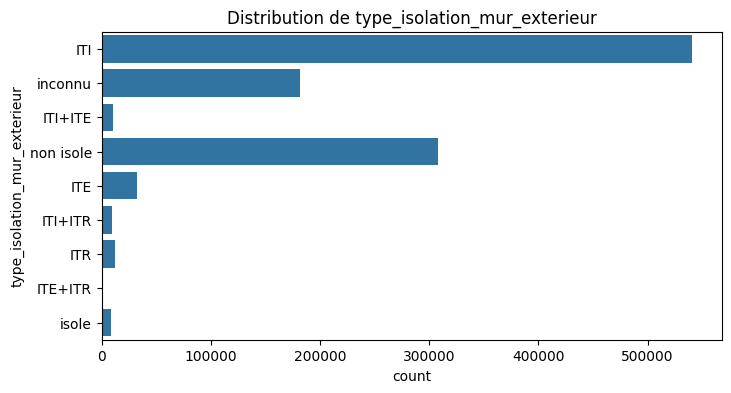

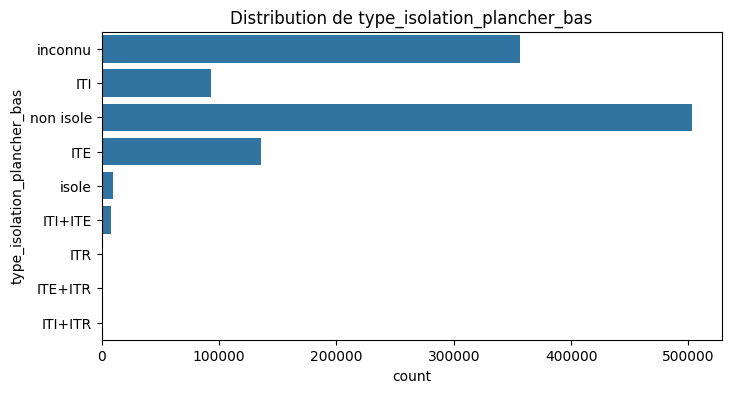

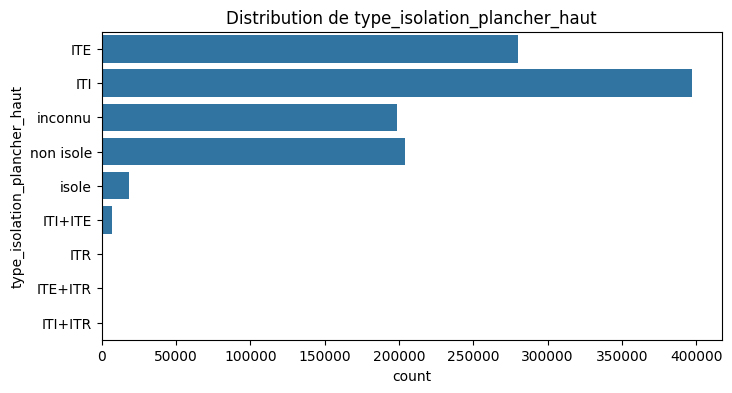

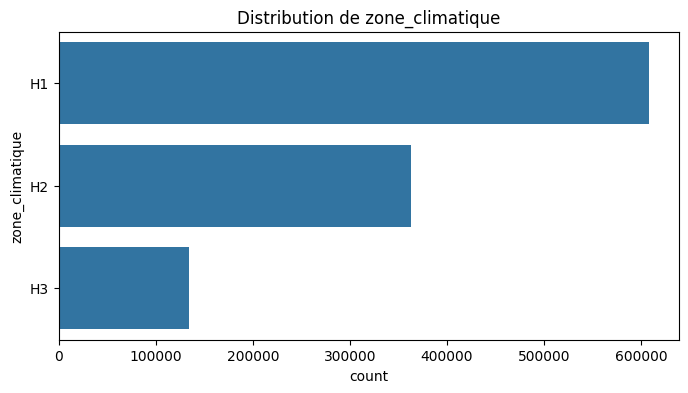

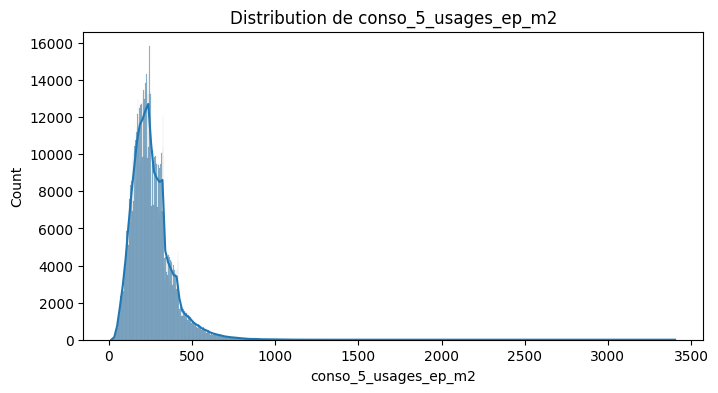

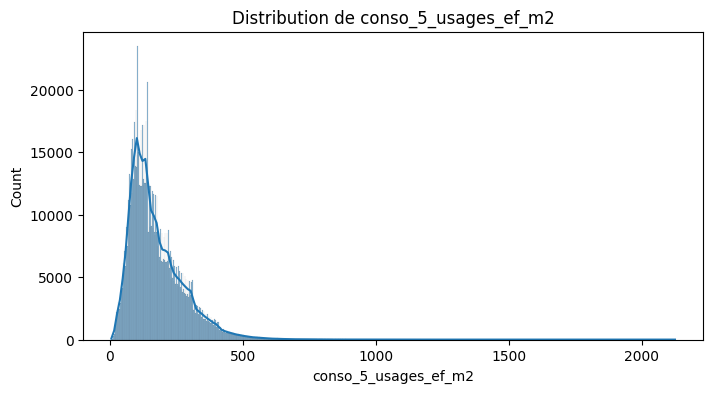

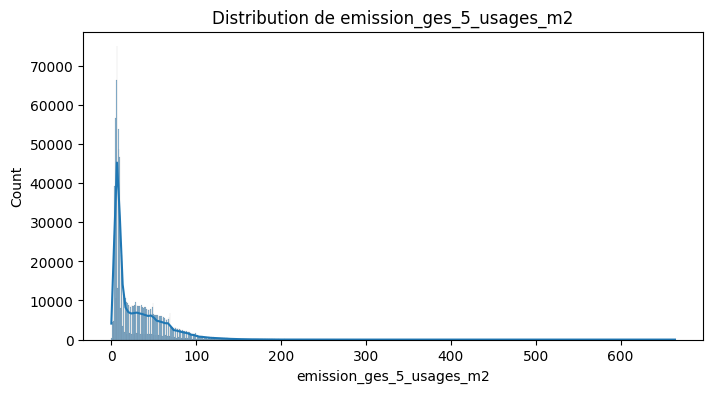

In [ ]:
# Définir les types de données pour choisir les graphiques appropriés
num_cols = X.select_dtypes(include=['float16', 'int16']).columns
cat_cols = X.select_dtypes(include=['object']).columns
num_cols_y = y.select_dtypes(include=['float16', 'int16']).columns



# Tracer les distributions pour les colonnes numériques
for col in num_cols:
    plt.figure(figsize=(8, 4))
    sns.histplot(X[col], kde=True)  # KDE pour estimation de la densité
    plt.title(f'Distribution de {col}')
    plt.show()

# Tracer les distributions pour les colonnes catégorielles
for col in cat_cols:
    plt.figure(figsize=(8, 4))
    # Compter la fréquence des catégories et tracer un diagramme à barres
    sns.countplot(y=col, data=X)
    plt.title(f'Distribution de {col}')
    plt.show()
for col in num_cols_y:
    plt.figure(figsize=(8, 4))
    sns.histplot(y[col], kde=True)  # KDE pour estimation de la densité
    plt.title(f'Distribution de {col}')
    plt.show()

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression

In [17]:
ohe_features = [
    "type_batiment_dpe",
    "periode_construction_dpe",
    "type_generateur_chauffage",
    "type_energie_chauffage_appoint",
    "nb_generateur_chauffage",
    #"nb_installation_chauffage",
     #"type_energie_climatisation",
    "type_generateur_climatisation",
    #"type_energie_ecs",
    "type_generateur_ecs",
    "nb_generateur_ecs",
    #"nb_installation_ecs",
    "type_ventilation",
    "type_vitrage",
    "type_materiaux_menuiserie",
    "type_fermeture",
    "type_isolation_mur_exterieur",
    "type_isolation_plancher_bas",
    "type_isolation_plancher_haut",
    "traversant",
    "type_gaz_lame",
    "zone_climatique"
]
numeric_features = ["surface_habitable_logement"]
ord_features = [
    "type_installation_chauffage",
    "chauffage_solaire",
    "type_installation_ecs",
    "ecs_solaire",
    "type_production_energie_renouvelable",
]

In [18]:
preprocessor = ColumnTransformer(
    transformers=[
        ('ord_cat',OrdinalEncoder(),ord_features),
        ('cat', OneHotEncoder(handle_unknown='ignore',sparse_output = False), ohe_features),
        ('num', MinMaxScaler(), numeric_features)
    ],
    remainder='drop'
)


In [19]:
X_df_preproc=pd.DataFrame(preprocessor.fit_transform(X),columns=preprocessor.get_feature_names_out())

In [20]:
del X

In [ ]:
correlation_matrix = X_df_preproc.corr()
column_names = correlation_matrix.columns
sns.heatmap(correlation_matrix, xticklabels=column_names, yticklabels=column_names,cmap= "bwr");

In [ ]:
# Converting the correlation matrix into a DataFrame
corr_df = correlation_matrix.stack().reset_index()

# Renaming the columns
corr_df.columns = ['feature_1','feature_2', 'correlation']

# Remove "self correlations"
no_self_correlation = (corr_df['feature_1'] != corr_df['feature_2'])
corr_df = corr_df[no_self_correlation]

In [ ]:
# Computing the absolute correlation
corr_df['absolute_correlation'] = np.abs(corr_df['correlation'])
# Showing the top 5 most correlated pairs of feature
corr_df.sort_values(by="absolute_correlation", ascending=False).head(20*2)

In [21]:
correlation_scores_1 = X_df_preproc.corrwith(y['conso_5_usages_ep_m2'])
correlation_scores_2 = X_df_preproc.corrwith(y['conso_5_usages_ef_m2'])
correlation_scores_3 = X_df_preproc.corrwith(y['emission_ges_5_usages_m2'])

In [22]:
top_features=correlation_scores_1.abs().nlargest(70)
top_feature_names = top_features.index.tolist()
X_df_preproc_top = X_df_preproc[top_feature_names]

In [25]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.svm import LinearSVR

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X_df_preproc, y.iloc[:,0], test_size=0.2, random_state=42)

In [ ]:
models_params = {
    'Decision Tree': {
        'model': DecisionTreeRegressor(),
        'params': {
            'max_depth': [None, 5, 10, 15],
            'min_samples_split': [2, 10, 20]
        }
    }
}
best_estimators = {}

In [ ]:
for name, spec in models_params.items():
    grid_search = GridSearchCV(spec['model'], spec['params'], cv=5, scoring='neg_mean_squared_error')
    grid_search.fit(X_train, y_train)
    best_estimators[name] = {
        'best_params': grid_search.best_params_,
        'best_score': -grid_search.best_score_
    }
    print(f"{name} best parameters: {grid_search.best_params_}")
    print(f"{name} best CV score (MSE): {-grid_search.best_score_}")

Decision Tree best parameters: {'max_depth': 10, 'min_samples_split': 20}
Decision Tree best CV score (MSE): 7497.387798014161


In [ ]:
for name, spec in best_estimators.items():
    model = models_params[name]['model']
    model.set_params(**spec['best_params'])  # Set best parameters
    model.fit(X_train, y_train)  # Refit with the best found parameters
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    print(f"{name} test MSE: {mse}")


Decision Tree test MSE: 193.84258925489772


894547     6.00
694703     7.00
259963    14.00
814743    20.00
887493     6.00
          ...  
110268     6.00
259178     8.82
131932    10.00
671155    12.72
121958    50.00
Name: emission_ges_5_usages_m2, Length: 885170, dtype: float64

In [28]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau

In [36]:


# Créer un modèle séquentiel
model = Sequential()

# Ajouter des couches denses au modèle
model.add(Dense(128, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dropout(0.3))
model.add(Dense(32, activation='relu'))  # Couche dense avec 32 neurones et fonction d'activation ReLU
model.add(Dropout(0.2))
model.add(Dense(1, activation='linear'))  # Couche de sortie avec 1 neurone pour la prédiction et activation linéaire



# Utilisation de l'optimiseur Adam et de la fonction de perte MSE, et suivi de la métrique MAE
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Stoppe l'entraînement si 'val_loss' ne s'améliore pas après 20 époques
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min', restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=11, min_lr=1e-7, verbose=1)

# Afficher un résumé du modèle
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 128)               23040     
                                                                 
 dropout_8 (Dropout)         (None, 128)               0         
                                                                 
 dense_13 (Dense)            (None, 32)                4128      
                                                                 
 dropout_9 (Dropout)         (None, 32)                0         
                                                                 
 dense_14 (Dense)            (None, 1)                 33        
                                                                 
Total params: 27201 (106.25 KB)
Trainable params: 27201 (106.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [38]:
# Entraîner le modèle sur un certain nombre d'époques
epochs = 140  # Nombre d'époques à entraîner le modèle

# Adapter le modèle aux données d'entraînement
history = model.fit(X_train, y_train, epochs=epochs , validation_split=0.2, callbacks=[early_stopping], verbose=1,batch_size=64)



11057/11057 [==============================] - 48s 4ms/step - loss: 5722.0835 - mae: 51.9674 - val_loss: 5316.5874 - val_mae: 50.7219
Epoch 43/200
11057/11057 [==============================] - 51s 5ms/step - loss: 5712.7734 - mae: 51.9421 - val_loss: 5315.6558 - val_mae: 50.1298
Epoch 44/200
11057/11057 [==============================] - 44s 4ms/step - loss: 5693.9448 - mae: 51.8694 - val_loss: 5307.0728 - val_mae: 50.4053
Epoch 45/200
11057/11057 [==============================] - 50s 4ms/step - loss: 5688.1924 - mae: 51.8361 - val_loss: 5330.4287 - val_mae: 50.5945
Epoch 45: early stopping


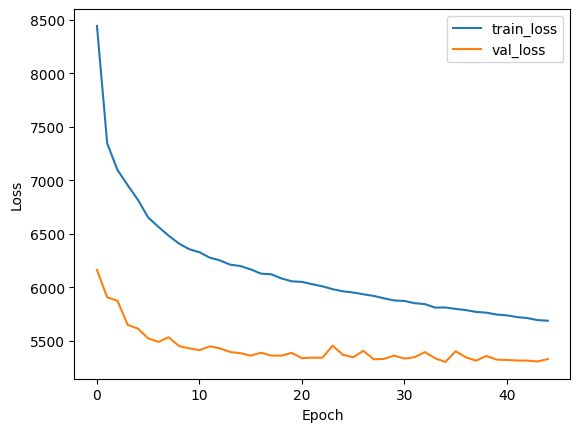

In [39]:
# Visualiser les métriques d'entraînement et de validation
import matplotlib.pyplot as plt

# Afficher les métriques d'entraînement et de validation (perte)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [40]:
from math import sqrt

In [41]:
mse,mae= model.evaluate(X_test, y_test, verbose=1)
print(f"MSE: {mse}")

# Calcul du MAE et RMSE
y_pred = model.predict(X_test)
rmse=sqrt(mse)

print(f"MAE: {mae}")
print(f"RMSE: {rmse}")

6911/6911 [==============================] - 17s 3ms/step - loss: 5241.0635 - mae: 49.6367
MSE: 5241.0634765625
6911/6911 [==============================] - 12s 2ms/step
MAE: 49.63668441772461
RMSE: 72.39518959545931


In [42]:
y_pred

array([[234.99454],
       [187.57362],
       [187.48053],
       ...,
       [319.74103],
       [292.2599 ],
       [272.78735]], dtype=float32)

In [44]:
y_pred_df = y_pred.flatten()  # Utilisez flatten() si y_pred est un array 2D de forme (n_samples, 1)

# Créer un DataFrame
results = pd.DataFrame({
    'y_test': y_test,  # y_test est déjà une série pandas, donc elle est prête à l'emploi
    'y_pred': y_pred_df
})

In [47]:
import seaborn as sns

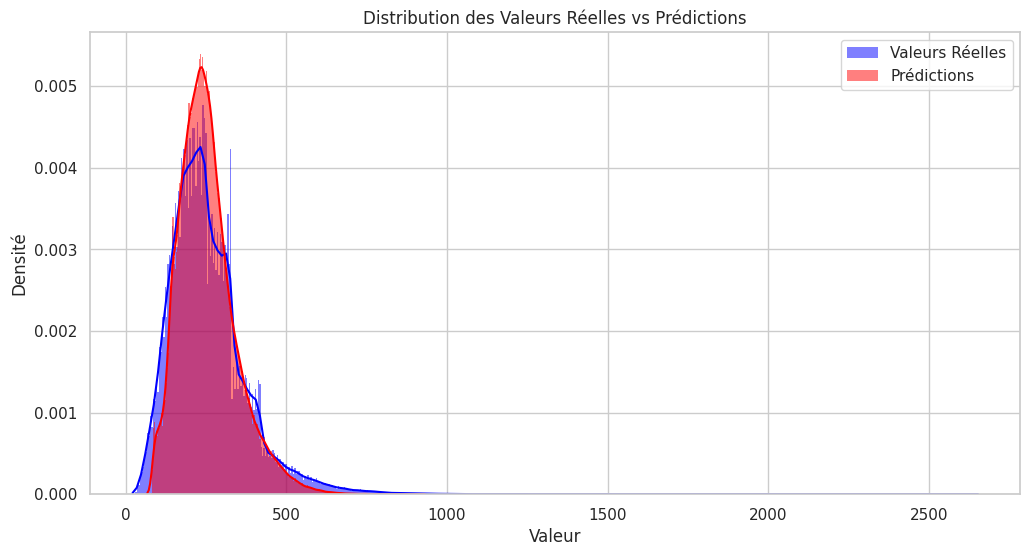

In [48]:
sns.set(style="whitegrid")

# Créer un graphique avec des histogrammes ou des kdeplot pour les distributions
plt.figure(figsize=(12, 6))

sns.histplot(results['y_test'], color="blue", label='Valeurs Réelles', kde=True, stat="density", linewidth=0)
sns.histplot(results['y_pred'], color="red", label='Prédictions', kde=True, stat="density", linewidth=0)

plt.title('Distribution des Valeurs Réelles vs Prédictions')
plt.xlabel('Valeur')
plt.ylabel('Densité')
plt.legend()

plt.show()

In [53]:
y_pred

array([[234.99454],
       [187.57362],
       [187.48053],
       ...,
       [319.74103],
       [292.2599 ],
       [272.78735]], dtype=float32)

In [60]:
X_train.cat__type_generateur_climatisation_aucun

231968     1.0
537930     1.0
105533     1.0
919107     1.0
1023691    1.0
          ... 
110268     1.0
259178     1.0
131932     0.0
671155     1.0
121958     1.0
Name: cat__type_generateur_climatisation_aucun, Length: 884540, dtype: float64

In [ ]:
# Tracer les distributions pour les colonnes catégorielles
for col in cat_cols:
    plt.figure(figsize=(8, 4))
    # Compter la fréquence des catégories et tracer un diagramme à barres
    sns.countplot(y=col, data=X)
    plt.title(f'Distribution de {col}')
    plt.show()
for col in num_cols_y:
    plt.figure(figsize=(8, 4))
    sns.histplot(y[col], kde=True)  # KDE pour estimation de la densité
    plt.title(f'Distribution de {col}')
    plt.show()